In [1]:
from bs4 import BeautifulSoup,Comment
import urllib.request
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFECV
#from pandas import DataFrame as df

In [2]:
#to get soup for 2020 team offense using Comment, used below
url = "https://www.pro-football-reference.com/years/2020/"
soup = BeautifulSoup(requests.get(url).content, 'html.parser')
table = soup.select_one('#all_team_stats').find_next(text=lambda t: isinstance(t, Comment))
table = BeautifulSoup(table, 'html.parser')



In [3]:
#what the HTML looks like
table.prettify()[0:2500]

'<div class="table_container" id="div_team_stats">\n <table class="per_match_toggle sortable stats_table" data-cols-to-freeze=",2" id="team_stats">\n  <caption>\n   Team Offense Table\n  </caption>\n  <colgroup>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n  </colgroup>\n  <thead>\n   <tr class="over_header">\n    <th aria-label="" class="over_header center" colspan="2" data-stat="">\n    </th>\n    <th>\n    </th>\n    <th>\n    </th>\n    <th>\n    </th>\n    <th aria-label="" class="over_header center" colspan="3" data-stat="header_tot_off_tgl">\n     Tot Yds &amp; TO\n    </th>\n    <th>\n    </th>\n    <th>\n    </th>\n    <th aria-label="" class="over_header center" colspan="7" data-stat="header_pass">\n     Passing\n   

In [4]:
#function to rename columns to unique Offense/Defense data and columns that are missing titles from HTML table
def rename_cols(df):
    dict = {'Unnamed: 0_level_0':'TotOff',
            'Unnamed: 1_level_0':'TotOff',
            'Unnamed: 2_level_0':'TotOff',
            'Unnamed: 3_level_0':'TotOff',
            'Unnamed: 4_level_0':'TotOff',
            'Passing' : 'O_Passing',
            'Rushing' : 'O_Rushing',
            'Penalties': 'O_Penalties',
            'Tot Yds & TO':'TotOff',
            'Unnamed: 8_level_0':'TotOff',
            'Unnamed: 9_level_0':'TotOff',
            'Unnamed: 25_level_0':'O_Score%',
            'Unnamed: 26_level_0':'O_TurnOver%',
            'Unnamed: 27_level_0':'O_EXP',}
        
    # call rename() method
    df.rename(columns=dict,inplace=True)
    return(df)

def rename_cols_DEF(df):
    dict = {'Unnamed: 0_level_0':'TotDef',
            'Unnamed: 1_level_0':'TotDef',
            'Unnamed: 2_level_0':'TotDef',
            'Unnamed: 3_level_0':'TotDef',
            'Unnamed: 4_level_0':'TotDef',
            'Passing' : 'D_Passing',
            'Rushing' : 'D_Rushing',
            'Penalties': 'D_Penalties',
            'Tot Yds & TO':'TotDef',
            'Unnamed: 8_level_0':'TotDef',
            'Unnamed: 9_level_0':'TotDef',
            'Unnamed: 25_level_0':'D_Score%',
            'Unnamed: 26_level_0':'D_TurnOver%',
            'Unnamed: 27_level_0':'D_EXP',}
        
    # call rename() method
    df.rename(columns=dict,inplace=True)
    return(df)

In [5]:
#Get Team Offense Data
#for loop to get data for X years


year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
OFFdfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.select_one('#all_team_stats').find_next(text=lambda t: isinstance(t, Comment))
    table = BeautifulSoup(table, 'html.parser')    
    #create DF from html table, drop last 3 rows of data 
    OFFdf = pd.read_html(str(table))[0]
    curr_year = year - count
    OFFdf['Year'] = curr_year
    OFFdfs.append(OFFdf[:-3])
    count+=1


#initialize Master Team Offense Dataframe    
MasterOFF = OFFdfs[0]

for i in range(len(OFFdfs)-1):    
    #append DF to master, reset index to continuous
    MasterOFF = MasterOFF.append(OFFdfs[i+1],ignore_index = True)

#rename columns to useful index    
MasterOFF = rename_cols(MasterOFF)
#drop multi-index
MasterOFF.columns = ['_'.join(col) for col in MasterOFF.columns]
#cleanup Year column index
MasterOFF.rename(columns={'Year_':'Year'},inplace=True)

In [6]:
#Get Team Defense Data
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
year = 2020
DEFdfs = []
ADV_DEFdf = []
Team_Sacks = pd.DataFrame(['Tm','Sk'])
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/opp.htm')
    years = year - index

    
#mask for advanced_defense table data
sacks = ['Tm','Sk','Year']

#team_stats table does not include Sacks, so need passing table data and merge tables.
count = 0
for index in urls:
    curr_year = year - count
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.find('table', id = 'team_stats') 
    table2 = soup.select_one('#all_passing').find_next(text=lambda t: isinstance(t, Comment))
    table2 = BeautifulSoup(table2, 'html.parser')
    #create DF from html table, drop last 3 rows of data 
    DEFdf = pd.read_html(str(table))[0]
    DEFdf.drop(DEFdf.tail(3).index, inplace = True)
    #rename each DF
    rename_cols_DEF(DEFdf)
    #add year data
    DEFdf['Year'] = curr_year
    #drop multi-index
    DEFdf.columns = ['_'.join(col) for col in DEFdf.columns]
    
    ADV_DEFdf = pd.read_html(str(table2))[0]
    ADV_DEFdf.drop(ADV_DEFdf.tail(3).index,inplace = True)
    ADV_DEFdf['Year'] = curr_year
    #apply mask
    Team_Sacks = ADV_DEFdf[sacks].copy()
    #intermediate step prior to appending data. merges team_stats and team sacks data 
    DEFdf_interm = pd.merge(DEFdf,Team_Sacks, left_on =['TotDef_Tm'], right_on = ['Tm'] )
    #append to list of team defense data
   
    DEFdfs.append(DEFdf_interm)
    count+=1


#initialize master DataFrame with first list of Team Defense data
MasterDEF = DEFdfs[0]

for i in range(len(DEFdfs)-1):    
    #append DF to master, reset index to continuous
    MasterDEF = MasterDEF.append(DEFdfs[i+1],ignore_index = True)
    
MasterDEF.drop('Tm',axis = 1,inplace=True)
MasterDEF.drop('Year_',axis = 1,inplace=True)
MasterDEF.head(5)

,TotDef_Rk,TotDef_Tm,TotDef_G,TotDef_PF,TotDef_Yds,TotDef_Ply,TotDef_Y/P,TotDef_TO,TotDef_FL,TotDef_1stD,...,D_Rushing_Y/A,D_Rushing_1stD,D_Penalties_Pen,D_Penalties_Yds,D_Penalties_1stPy,D_Score%_Sc%,D_TurnOver%_TO%,D_EXP_EXP,Sk,Year
0,1.0,Los Angeles Rams,16.0,296.0,4511.0,989.0,4.6,22.0,8.0,280.0,...,3.8,91.0,78.0,582.0,19.0,27.9,12.0,85.89,53.0,2020
1,2.0,Baltimore Ravens,16.0,303.0,5276.0,1017.0,5.2,22.0,12.0,347.0,...,4.6,96.0,77.0,646.0,38.0,30.0,12.4,-17.69,39.0,2020
2,3.0,Pittsburgh Steelers,16.0,312.0,4893.0,996.0,4.9,27.0,9.0,281.0,...,4.3,94.0,103.0,980.0,24.0,29.3,13.8,33.24,56.0,2020
3,4.0,Washington Football Team,16.0,329.0,4873.0,1004.0,4.9,23.0,7.0,289.0,...,4.2,100.0,85.0,708.0,28.0,31.4,12.2,32.51,47.0,2020
4,5.0,New Orleans Saints,16.0,337.0,4974.0,992.0,5.0,26.0,8.0,320.0,...,3.9,85.0,64.0,517.0,50.0,34.7,13.1,-40.02,45.0,2020


In [7]:
#get standings inlcuding win-loss record

#for loop to get data for X years
year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
AFCStandDfs = []
NFCStandDfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    #AFCtable = soup.select('table', id='AFC')
    #NFCtable = soup.select('table', id='NFC')
    AFCtable = soup.findAll('table', {'id':['AFC']})
    NFCtable = soup.findAll('table', {'id':['NFC']})
    AFCStandDf = pd.read_html(str(AFCtable))[0]
    NFCStandDf = pd.read_html(str(NFCtable))[0]
    curr_year = year - count
    AFCStandDf['Year'] = curr_year
    AFCStandDfs.append(AFCStandDf)
    NFCStandDf['Year'] = curr_year
    NFCStandDfs.append(NFCStandDf)    
    count+=1


#initialize Dataframe    
AFCStandings = AFCStandDfs[0]
NFCStandings = NFCStandDfs[0]
for i in range(len(AFCStandDfs)-1):    
    #append DF, reset index to continuous
    AFCStandings = AFCStandings.append(AFCStandDfs[i+1],ignore_index = True)
for i in range(len(NFCStandDfs)-1):
    NFCStandings = NFCStandings.append(NFCStandDfs[i+1],ignore_index = True)

#drop conference labels (north,east,west,south)    
AFCStandings.drop(AFCStandings.index[0:len(AFCStandings):5], inplace = True)
NFCStandings.drop(NFCStandings.index[0:len(NFCStandings):5], inplace = True)

#strip character marker
AFCStandings['Tm'] = AFCStandings['Tm'].str.rstrip('*'+'+')
NFCStandings['Tm'] = NFCStandings['Tm'].str.rstrip('*'+'+')

#combine standings
Standings = NFCStandings.append(AFCStandings)

Standings.drop(['MoV','SoS','SRS','OSRS','DSRS','PF','PA'],axis = 1,inplace = True)

#change object type to float
Standings['W'] = Standings['W'].astype(float)
Standings['L'] = Standings['L'].astype(float)
Standings['T'] = Standings['T'].astype(float)
Standings['W-L%'] = Standings['W-L%'].astype(float)
Standings['PD'] = Standings['PD'].astype(float)
Standings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 1 to 199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tm      320 non-null    object 
 1   W       320 non-null    float64
 2   L       320 non-null    float64
 3   T       224 non-null    float64
 4   W-L%    320 non-null    float64
 5   PD      320 non-null    float64
 6   Year    320 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 20.0+ KB


In [8]:
#get playoff results data
#includes winner and score

#for loop to get data for X years


year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
PlayOffdfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.select_one('#all_playoff_results').find_next(text=lambda t: isinstance(t, Comment))
    table = BeautifulSoup(table, 'html.parser') 
    PlayOffdf = pd.read_html(str(table))[0]
    curr_year = year - count
    PlayOffdf['Year'] = curr_year
    PlayOffdfs.append(PlayOffdf)
    count+=1


#initialize Playoffs Dataframe    
PlayOffs = PlayOffdfs[0]

for i in range(len(PlayOffdfs)-1):    
    #append DF, reset index to continuous
    PlayOffs = PlayOffs.append(PlayOffdfs[i+1],ignore_index = True)





In [9]:
PlayOffs.head(13)

,Week,Day,Date,Winner/tie,Unnamed: 4,Loser/tie,Unnamed: 6,Pts,Pts.1,Year
0,WildCard,Sat,2021-01-09,Buffalo Bills,NaN,Indianapolis Colts,boxscore,27,24,2020
1,WildCard,Sat,2021-01-09,Los Angeles Rams,@,Seattle Seahawks,boxscore,30,20,2020
2,WildCard,Sat,2021-01-09,Tampa Bay Buccaneers,@,Washington Football Team,boxscore,31,23,2020
3,WildCard,Sun,2021-01-10,Cleveland Browns,@,Pittsburgh Steelers,boxscore,48,37,2020
4,WildCard,Sun,2021-01-10,New Orleans Saints,NaN,Chicago Bears,boxscore,21,9,2020
5,WildCard,Sun,2021-01-10,Baltimore Ravens,@,Tennessee Titans,boxscore,20,13,2020
6,Division,Sat,2021-01-16,Green Bay Packers,NaN,Los Angeles Rams,boxscore,32,18,2020
7,Division,Sat,2021-01-16,Buffalo Bills,NaN,Baltimore Ravens,boxscore,17,3,2020
8,Division,Sun,2021-01-17,Kansas City Chiefs,NaN,Cleveland Browns,boxscore,22,17,2020
9,Division,Sun,2021-01-17,Tampa Bay Buccaneers,@,New Orleans Saints,boxscore,30,20,2020


In [10]:
PlayOffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Week        112 non-null    object
 1   Day         112 non-null    object
 2   Date        112 non-null    object
 3   Winner/tie  112 non-null    object
 4   Unnamed: 4  46 non-null     object
 5   Loser/tie   112 non-null    object
 6   Unnamed: 6  112 non-null    object
 7   Pts         112 non-null    int64 
 8   Pts.1       112 non-null    int64 
 9   Year        112 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 8.9+ KB


In [11]:
PlayOffs.keys()

Index(['Week', 'Day', 'Date', 'Winner/tie', 'Unnamed: 4', 'Loser/tie',
       'Unnamed: 6', 'Pts', 'Pts.1', 'Year'],
      dtype='object')

In [12]:
SBWinner = PlayOffs.loc[PlayOffs['Week']=='SuperBowl']

In [13]:
SBWinner

,Week,Day,Date,Winner/tie,Unnamed: 4,Loser/tie,Unnamed: 6,Pts,Pts.1,Year
12,SuperBowl,Sun,2021-02-07,Tampa Bay Buccaneers,N,Kansas City Chiefs,boxscore,31,9,2020
23,SuperBowl,Sun,2020-02-02,Kansas City Chiefs,N,San Francisco 49ers,boxscore,31,20,2019
34,SuperBowl,Sun,2019-02-03,New England Patriots,N,Los Angeles Rams,boxscore,13,3,2018
45,SuperBowl,Sun,2018-02-04,Philadelphia Eagles,N,New England Patriots,boxscore,41,33,2017
56,SuperBowl,Sun,2017-02-05,New England Patriots,N,Atlanta Falcons,boxscore,34,28,2016
67,SuperBowl,Sun,2016-02-07,Denver Broncos,N,Carolina Panthers,boxscore,24,10,2015
78,SuperBowl,Sun,2015-02-01,New England Patriots,N,Seattle Seahawks,boxscore,28,24,2014
89,SuperBowl,Sun,2014-02-02,Seattle Seahawks,N,Denver Broncos,boxscore,43,8,2013
100,SuperBowl,Sun,2013-02-03,Baltimore Ravens,N,San Francisco 49ers,boxscore,34,31,2012
111,SuperBowl,Sun,2012-02-05,New York Giants,N,New England Patriots,boxscore,21,17,2011


In [14]:
#assigning binary superbowl win column to master team offense dataframe.
#this block should be put into a for loop

MasterOFF[('SB_Win')] = 0

row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Tampa Bay Buccaneers') & (MasterOFF['Year'] == 2020)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Kansas City Chiefs') & (MasterOFF['Year'] == 2019)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2018)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Philadelphia Eagles') & (MasterOFF['Year'] == 2017)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2016)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Denver Broncos') & (MasterOFF['Year'] == 2015)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2014)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Seattle Seahawks') & (MasterOFF['Year'] == 2013)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Baltimore Ravens') & (MasterOFF['Year'] == 2012)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New York Giants') & (MasterOFF['Year'] == 2011)].index
MasterOFF.at[row[0],('SB_Win')] = 1


MasterOFF.head(5)


,TotOff_Rk,TotOff_Tm,TotOff_G,TotOff_PF,TotOff_Yds,TotOff_Ply,TotOff_Y/P,TotOff_TO,TotOff_FL,TotOff_1stD,...,O_Rushing_Y/A,O_Rushing_1stD,O_Penalties_Pen,O_Penalties_Yds,O_Penalties_1stPy,O_Score%_Sc%,O_TurnOver%_TO%,O_EXP_EXP,Year,SB_Win
0,1.0,Green Bay Packers,16.0,509.0,6224.0,990.0,6.3,11.0,6.0,358.0,...,4.8,114.0,84.0,684.0,28.0,49.7,5.6,290.75,2020,0
1,2.0,Buffalo Bills,16.0,501.0,6343.0,1034.0,6.1,22.0,11.0,397.0,...,4.2,119.0,102.0,941.0,38.0,49.4,11.8,228.66,2020,0
2,3.0,Tampa Bay Buccaneers,16.0,492.0,6145.0,1017.0,6.0,17.0,5.0,364.0,...,4.1,82.0,84.0,715.0,44.0,47.8,8.9,246.24,2020,1
3,4.0,Tennessee Titans,16.0,491.0,6343.0,1031.0,6.2,12.0,5.0,381.0,...,5.2,142.0,86.0,783.0,36.0,47.9,7.2,245.01,2020,0
4,5.0,New Orleans Saints,16.0,482.0,6023.0,1045.0,5.8,17.0,9.0,367.0,...,4.6,147.0,98.0,1005.0,21.0,45.5,9.0,176.94,2020,0


In [15]:
#Year = MasterOFF['Year'] == 2020
Year = SBWinner['Year'] == 2020

SBWinner.loc[Year]['Winner/tie']

12    Tampa Bay Buccaneers
Name: Winner/tie, dtype: object

In [ ]:
#relationship plot

sns.relplot(
    data=MasterOFFcopy,
    x="TotOff_PF", y="TotOff_Yds", col="Year", hue="SB_Win")

In [17]:
#Combine Offense and Defense Dataframes
DF_OFF_DEF = pd.merge(MasterOFF,MasterDEF, left_on =['TotOff_Tm','Year'], right_on = ['TotDef_Tm','Year'], how = 'left' )


In [18]:
DF_OFF_DEF.head(5)

,TotOff_Rk,TotOff_Tm,TotOff_G,TotOff_PF,TotOff_Yds,TotOff_Ply,TotOff_Y/P,TotOff_TO,TotOff_FL,TotOff_1stD,...,D_Rushing_TD,D_Rushing_Y/A,D_Rushing_1stD,D_Penalties_Pen,D_Penalties_Yds,D_Penalties_1stPy,D_Score%_Sc%,D_TurnOver%_TO%,D_EXP_EXP,Sk
0,1.0,Green Bay Packers,16.0,509.0,6224.0,990.0,6.3,11.0,6.0,358.0,...,16.0,4.5,119.0,79.0,734.0,29.0,39.9,11.4,-109.67,41.0
1,2.0,Buffalo Bills,16.0,501.0,6343.0,1034.0,6.1,22.0,11.0,397.0,...,21.0,4.6,125.0,86.0,728.0,27.0,39.4,15.3,-123.10,38.0
2,3.0,Tampa Bay Buccaneers,16.0,492.0,6145.0,1017.0,6.0,17.0,5.0,364.0,...,10.0,3.6,78.0,95.0,1015.0,26.0,33.7,14.0,-22.04,48.0
3,4.0,Tennessee Titans,16.0,491.0,6343.0,1031.0,6.2,12.0,5.0,381.0,...,18.0,4.5,113.0,103.0,840.0,31.0,45.2,13.3,-185.20,19.0
4,5.0,New Orleans Saints,16.0,482.0,6023.0,1045.0,5.8,17.0,9.0,367.0,...,11.0,3.9,85.0,64.0,517.0,50.0,34.7,13.1,-40.02,45.0


In [20]:
#merge offense, defense, and standings data
DF= pd.merge(DF_OFF_DEF,Standings, left_on =['TotOff_Tm','Year'], right_on = ['Tm','Year'])
DF.drop(['TotOff_Tm','TotDef_Tm','TotOff_G','TotDef_G','T'],axis = 1,inplace = True)

In [ ]:
SB_all_ols2 = sm.Logit(DF.endog,DF.exog).fit()
SB_all_ols2.summary()

In [ ]:
Var_Corr = DF.corr()
# plot the heatmap and annotation on it
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, ax = ax)

In [ ]:
print(DF.keys())

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [23]:
X = DF.drop(['SB_Win','Tm'],axis=1)
Y = DF['SB_Win']

In [85]:
x_train, x_test, y_train, y_test = train_test_split(X[['TotOff_TO', 'TotOff_FL', 'O_Passing_Int',
       'O_Passing_1stD', 'O_Rushing_1stD', 'O_Penalties_1stPy',
       'TotDef_Ply', 'TotDef_FL', 'TotDef_1stD', 'D_Passing_Att',
       'D_Passing_Yds', 'D_Passing_Int', 'D_Rushing_Att',
       'D_Rushing_Yds', 'D_Rushing_1stD', 'D_Penalties_1stPy', 'Sk']], Y)

In [ ]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train)
#log_reg = LogisticRegression(multi_class = 'multinomial',max_iter = 200)
#log_reg.fit(x_train,y_train)
#y_pred = log_reg.predict(x_test)

In [ ]:
pipe.score(x_test, y_test)

In [93]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train,y_train)
y_pred = LR.predict(x_test)
yhat_binary = LR.predict(x_train)
print("Accuracy:",metrics.accuracy_score(y_train, yhat_binary))
yhat_prob = LR.predict_proba(X[['TotOff_TO', 'TotOff_FL', 'O_Passing_Int',
       'O_Passing_1stD', 'O_Rushing_1stD', 'O_Penalties_1stPy',
       'TotDef_Ply', 'TotDef_FL', 'TotDef_1stD', 'D_Passing_Att',
       'D_Passing_Yds', 'D_Passing_Int', 'D_Rushing_Att',
       'D_Rushing_Yds', 'D_Rushing_1stD', 'D_Penalties_1stPy', 'Sk']])
X['Tm'] = DF['Tm']
X['Year'] = DF['Year']
df2 = X
df2['Prob'] = yhat_prob[:,1]
df2.head(50)

Accuracy: 0.9708333333333333


,TotOff_Rk,TotOff_PF,TotOff_Yds,TotOff_Ply,TotOff_Y/P,TotOff_TO,TotOff_FL,TotOff_1stD,O_Passing_Cmp,O_Passing_Att,...,D_Score%_Sc%,D_TurnOver%_TO%,D_EXP_EXP,Sk,W,L,W-L%,PD,Prob,Tm
0,1.0,509.0,6224.0,990.0,6.3,11.0,6.0,358.0,372.0,526.0,...,39.9,11.4,-109.67,41.0,13.0,3.0,0.813,140.0,0.071112,Green Bay Packers
1,2.0,501.0,6343.0,1034.0,6.1,22.0,11.0,397.0,410.0,596.0,...,39.4,15.3,-123.10,38.0,13.0,3.0,0.813,126.0,0.041366,Buffalo Bills
2,3.0,492.0,6145.0,1017.0,6.0,17.0,5.0,364.0,410.0,626.0,...,33.7,14.0,-22.04,48.0,11.0,5.0,0.688,137.0,0.081811,Tampa Bay Buccaneers
3,4.0,491.0,6343.0,1031.0,6.2,12.0,5.0,381.0,316.0,485.0,...,45.2,13.3,-185.20,19.0,11.0,5.0,0.688,52.0,0.085095,Tennessee Titans
4,5.0,482.0,6023.0,1045.0,5.8,17.0,9.0,367.0,370.0,522.0,...,34.7,13.1,-40.02,45.0,12.0,4.0,0.750,145.0,0.024034,New Orleans Saints
5,6.0,473.0,6653.0,1057.0,6.3,16.0,9.0,397.0,420.0,630.0,...,36.1,13.0,-127.89,32.0,14.0,2.0,0.875,111.0,0.079378,Kansas City Chiefs
6,7.0,468.0,5810.0,993.0,5.9,18.0,7.0,327.0,257.0,406.0,...,30.0,12.4,-17.69,39.0,11.0,5.0,0.688,165.0,0.011257,Baltimore Ravens
7,8.0,459.0,5912.0,1022.0,5.8,18.0,5.0,356.0,388.0,563.0,...,40.0,12.0,-85.81,46.0,12.0,4.0,0.750,88.0,0.005627,Seattle Seahawks
8,9.0,451.0,6049.0,1032.0,5.9,15.0,4.0,364.0,371.0,552.0,...,35.1,14.3,-75.62,40.0,11.0,5.0,0.688,89.0,0.025239,Indianapolis Colts
9,10.0,434.0,6133.0,1036.0,5.9,26.0,16.0,359.0,369.0,551.0,...,50.3,8.4,-211.22,21.0,8.0,8.0,0.500,-44.0,0.009343,Las Vegas Raiders


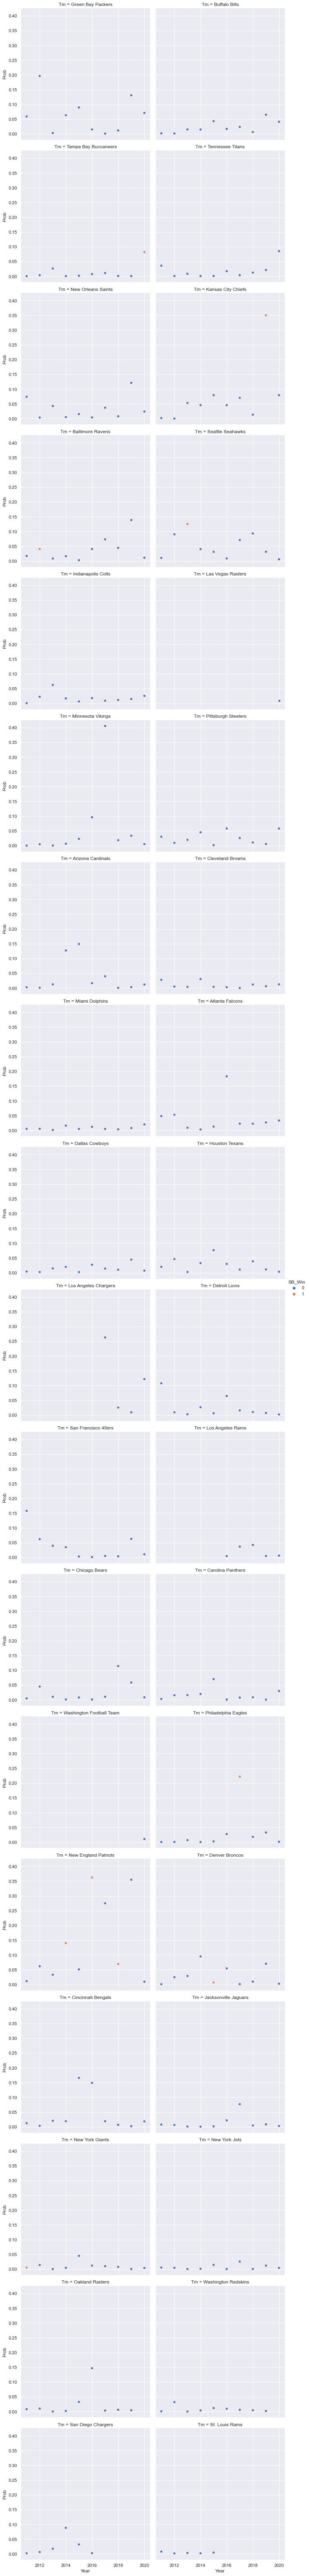

In [108]:
df2['SB_Win'] = DF['SB_Win']
TByearly = df2[df2['Tm'] == 'Tampa Bay Buccaneers']

TByearly.head()
sns.relplot(
    data=df2,
    x="Year", y="Prob",col='Tm',col_wrap = 2, hue="SB_Win")
#df2[["Prob",'Year','Tm']].value_counts().sort_index()
#yearly.plot.line()

In [55]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [ ]:
# automatically choose the number of features
rfe = RFECV(estimator=DecisionTreeClassifier())

In [56]:
# define dataset

model = LogisticRegression(C=0.01, solver='liblinear')
# create pipeline
rfe = RFE(model,52)

pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Accuracy: 0.957 (0.025)


In [57]:
print(n_scores)

[0.9375  1.      0.96875 0.9375  0.9375  0.96875 0.96875 0.9375  0.96875
 0.9375  0.96875 1.      0.96875 0.9375  0.9375  0.9375  0.96875 0.9375
 1.      0.9375  0.96875 0.96875 1.      0.9375  0.9375  1.      0.9375
 0.90625 0.9375  0.96875]


In [61]:
#no of features
nof_list=np.arange(1,30)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    #X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state = 0)
    model = LinearRegression()
    rfe = RFECV(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X,Y)
    X_test_rfe = rfe.transform(X)
    model.fit(X_train_rfe,Y)
    score = model.score(X_test_rfe,Y)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass step=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass step=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass step=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass step=4 as keyword args. From version 0.25 passing thes

Optimum number of features: 4
Score with 4 features: 0.045485


/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass step=28 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass step=29 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [62]:
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 52)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
X_test_rfe = rfe.transform(X_test)
model.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)
score = model.score(X_test_rfe,y_test)

/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


NameError: name 'X_test' is not defined

In [54]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.1):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['TotOff_Yds', 'TotOff_Ply', 'TotOff_Y/P', 'O_Passing_1stD', 'O_Rushing_Yds', 'O_Penalties_Yds', 'O_Penalties_1stPy', 'O_EXP_EXP', 'D_Rushing_Att', 'D_Penalties_Yds', 'D_EXP_EXP']


In [38]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 319
Data columns (total 60 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TotOff_Rk          320 non-null    float64
 1   TotOff_PF          320 non-null    float64
 2   TotOff_Yds         320 non-null    float64
 3   TotOff_Ply         320 non-null    float64
 4   TotOff_Y/P         320 non-null    float64
 5   TotOff_TO          320 non-null    float64
 6   TotOff_FL          320 non-null    float64
 7   TotOff_1stD        320 non-null    float64
 8   O_Passing_Cmp      320 non-null    float64
 9   O_Passing_Att      320 non-null    float64
 10  O_Passing_Yds      320 non-null    float64
 11  O_Passing_TD       320 non-null    float64
 12  O_Passing_Int      320 non-null    float64
 13  O_Passing_NY/A     320 non-null    float64
 14  O_Passing_1stD     320 non-null    float64
 15  O_Rushing_Att      320 non-null    float64
 16  O_Rushing_Yds      320 non

In [45]:
mask = DF[['TotOff_Ply','TotOff_Y/P','O_Passing_1stD','O_Rushing_Yds','O_EXP_EXP','D_EXP_EXP']]

In [ ]:
Y = sm.add_constant(Y)
mask = DF['TotOff_Ply','TotOff_Y/P']
SB_all_ols = sm.OLS(X,Y ).fit()
SB_all_ols.summary()

In [47]:
x = sm.add_constant(X)
SB_all_ols = sm.Logit(Y,X[['Sk','W-L%','TotOff_Ply', 'TotOff_Y/P', 'O_Passing_1stD', 'O_Rushing_Yds', 'O_EXP_EXP', 'D_EXP_EXP']]).fit()
SB_all_ols.summary()

Optimization terminated successfully.
         Current function value: 0.078652
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 SB_Win   No. Observations:                  320
Model:                          Logit   Df Residuals:                      312
Method:                           MLE   Df Model:                            7
Date:                Fri, 23 Apr 2021   Pseudo R-squ.:                  0.4344
Time:                        10:20:39   Log-Likelihood:                -25.169
converged:                       True   LL-Null:                       -44.499
Covariance Type:            nonrobust   LLR p-value:                 2.267e-06
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Sk                -0.0811      0.059     -1.366      0.172      -0.197       0.035
W-L%               1.4561      4.324      0.337      0.736      -7.018       9.931
TotOff_Ply         0.0169      0.009      1.861      0.063      -0.001       0.035
TotOff_Y/P         1.4145      1.287      1.099      0.272      -1.108       3.937
O_Passing_1stD    -0.0845      0.037     -2.311      0.021      -0.156      -0.013
O_Rushing_Yds     -0.0068      0.002     -2.905      0.004      -0.011      -0.002
O_EXP_EXP          0.0337      0.010      3.507      0.000       0.015       0.053
D_EXP_EXP          0.0280      0.009      2.952      0.003       0.009       0.047
==================================================================================

Possibly complete quasi-separation: A fraction 0.12 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [50]:
x = sm.add_constant(X)
SB_all_ols = sm.OLS(Y,X[['Sk','W-L%','TotOff_Ply', 'TotOff_Y/P', 'O_Passing_1stD', 'O_Rushing_Yds', 'O_EXP_EXP', 'D_EXP_EXP']]).fit()
SB_all_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 SB_Win   R-squared (uncentered):                   0.138
Model:                            OLS   Adj. R-squared (uncentered):              0.116
Method:                 Least Squares   F-statistic:                              6.230
Date:                Fri, 23 Apr 2021   Prob (F-statistic):                    1.77e-07
Time:                        10:23:37   Log-Likelihood:                          124.17
No. Observations:                 320   AIC:                                     -232.3
Df Residuals:                     312   BIC:                                     -202.2
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Sk                -0.0012      0.001     -0.943      0.346      -0.004       0.001
W-L%              -0.0082      0.086     -0.095      0.924      -0.178       0.162
TotOff_Ply         0.0006      0.000      3.031      0.003       0.000       0.001
TotOff_Y/P         0.0635      0.030      2.153      0.032       0.005       0.122
O_Passing_1stD    -0.0026      0.001     -3.435      0.001      -0.004      -0.001
O_Rushing_Yds     -0.0002   5.02e-05     -3.748      0.000      -0.000   -8.94e-05
O_EXP_EXP          0.0008      0.000      4.134      0.000       0.000       0.001
D_EXP_EXP          0.0006      0.000      3.372      0.001       0.000       0.001
==============================================================================
Omnibus:                      323.689   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7144.976
Skew:                           4.524   Prob(JB):                         0.00
Kurtosis:                      24.307   Cond. No.                     1.97e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
x = sm.add_constant(X)
SB_all_ols = sm.Logit(Y,X[['Sk','W-L%','TotOff_Ply', 'TotOff_Y/P', 'O_Passing_1stD', 'O_Rushing_Yds', 'O_EXP_EXP', 'D_EXP_EXP']]).fit()
SB_all_ols.summary()

Optimization terminated successfully.
         Current function value: 0.078652
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 SB_Win   No. Observations:                  320
Model:                          Logit   Df Residuals:                      312
Method:                           MLE   Df Model:                            7
Date:                Fri, 23 Apr 2021   Pseudo R-squ.:                  0.4344
Time:                        10:32:01   Log-Likelihood:                -25.169
converged:                       True   LL-Null:                       -44.499
Covariance Type:            nonrobust   LLR p-value:                 2.267e-06
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Sk                -0.0811      0.059     -1.366      0.172      -0.197       0.035
W-L%               1.4561      4.324      0.337      0.736      -7.018       9.931
TotOff_Ply         0.0169      0.009      1.861      0.063      -0.001       0.035
TotOff_Y/P         1.4145      1.287      1.099      0.272      -1.108       3.937
O_Passing_1stD    -0.0845      0.037     -2.311      0.021      -0.156      -0.013
O_Rushing_Yds     -0.0068      0.002     -2.905      0.004      -0.011      -0.002
O_EXP_EXP          0.0337      0.010      3.507      0.000       0.015       0.053
D_EXP_EXP          0.0280      0.009      2.952      0.003       0.009       0.047
==================================================================================

Possibly complete quasi-separation: A fraction 0.12 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

<AxesSubplot:>

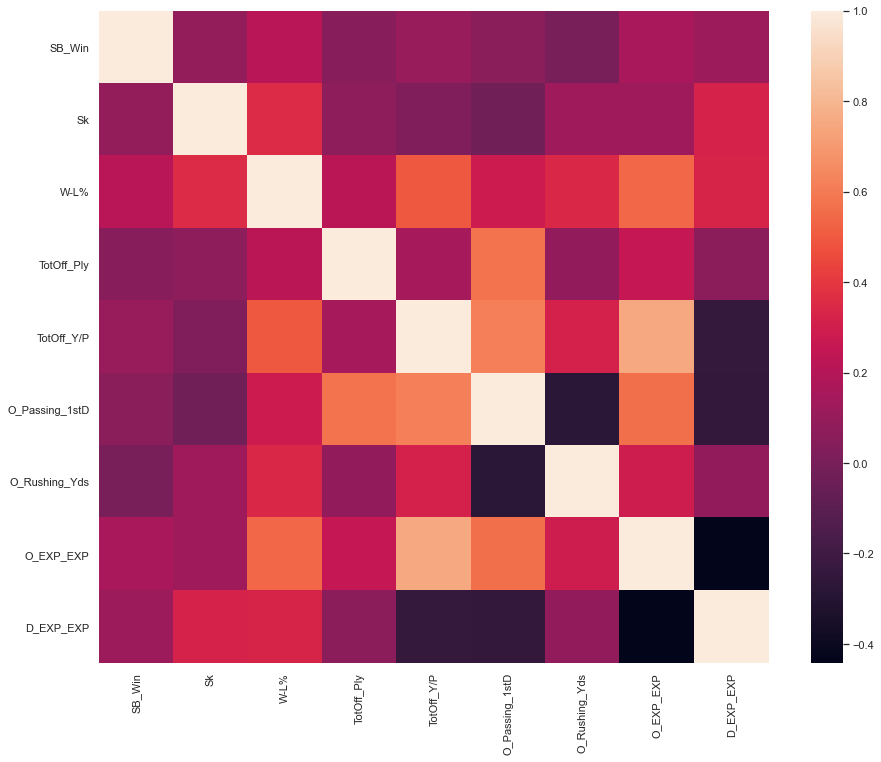

In [69]:
DF[['SB_Win','Sk','W-L%','TotOff_Ply', 'TotOff_Y/P', 'O_Passing_1stD', 'O_Rushing_Yds', 'O_EXP_EXP', 'D_EXP_EXP']].corr()

Var_Corr = DF[['SB_Win','Sk','W-L%','TotOff_Ply', 'TotOff_Y/P', 'O_Passing_1stD', 'O_Rushing_Yds', 'O_EXP_EXP', 'D_EXP_EXP']].corr()
# plot the heatmap and annotation on it
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, ax = ax)



In [73]:
from sklearn.ensemble import ExtraTreesClassifier

array = DF.drop('Tm',axis=1).values
X = array[:,0:58]
Y = array[:,58]
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)

[0.0175254  0.019519   0.01669777 0.01696881 0.01667697 0.00994706
 0.01513237 0.01928441 0.01699953 0.01473793 0.01868107 0.0218872
 0.02141839 0.02014136 0.01708252 0.01642821 0.01784711 0.01909111
 0.01621748 0.01284464 0.01654482 0.01651631 0.01567999 0.01529557
 0.01684611 0.01843201 0.0147832  0.00165188 0.01965662 0.01688351
 0.01391719 0.01795435 0.01584746 0.01881746 0.01852967 0.0174413
 0.01616957 0.01683892 0.01764434 0.01853721 0.01751045 0.01609239
 0.01364971 0.0167178  0.01964651 0.0201729  0.0165256  0.02135701
 0.01647602 0.01925439 0.01562635 0.0218761  0.0206239  0.01459695
 0.01851947 0.02320087 0.01883272 0.02020503]


In [74]:
X = DF.drop(['SB_Win','Tm'],axis=1)
Y = DF['SB_Win']
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 20)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Index(['TotOff_TO', 'TotOff_FL', 'TotOff_1stD', 'O_Passing_Int',
       'O_Passing_1stD', 'O_Rushing_1stD', 'O_Penalties_1stPy', 'TotDef_Yds',
       'TotDef_Ply', 'TotDef_FL', 'TotDef_1stD', 'D_Passing_Att',
       'D_Passing_Yds', 'D_Passing_Int', 'D_Passing_1stD', 'D_Rushing_Att',
       'D_Rushing_Yds', 'D_Rushing_1stD', 'D_Penalties_1stPy', 'Sk'],
      dtype='object')


In [79]:
SB_all_ols = sm.OLS(Y,X[['TotOff_TO', 'TotOff_FL', 'O_Passing_Int',
       'O_Passing_1stD', 'O_Rushing_1stD', 'O_Penalties_1stPy',
       'TotDef_Ply', 'TotDef_FL', 'TotDef_1stD', 'D_Passing_Att',
       'D_Passing_Yds', 'D_Passing_Int', 'D_Rushing_Att',
       'D_Rushing_Yds', 'D_Rushing_1stD', 'D_Penalties_1stPy', 'Sk']]).fit()
SB_all_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 SB_Win   R-squared (uncentered):                   0.101
Model:                            OLS   Adj. R-squared (uncentered):              0.057
Method:                 Least Squares   F-statistic:                              2.295
Date:                Fri, 23 Apr 2021   Prob (F-statistic):                     0.00426
Time:                        10:48:21   Log-Likelihood:                          117.57
No. Observations:                 320   AIC:                                     -205.1
Df Residuals:                     305   BIC:                                     -148.6
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
TotOff_TO            -0.0021      0.001     -1.696      0.091      -0.005       0.000
TotOff_FL            -0.0007      0.002     -0.282      0.778      -0.005       0.004
O_Passing_Int        -0.0015      0.002     -0.778      0.437      -0.005       0.002
O_Passing_1stD        0.0002      0.000      0.597      0.551      -0.000       0.001
O_Rushing_1stD       -0.0004      0.000     -0.750      0.454      -0.001       0.001
O_Penalties_1stPy     0.0029      0.001      2.030      0.043    8.88e-05       0.006
TotDef_Ply         4.949e-05      0.000      0.154      0.877      -0.001       0.001
TotDef_FL             0.0014      0.003      0.428      0.669      -0.005       0.008
TotDef_1stD          -0.0006      0.001     -0.532      0.595      -0.003       0.002
D_Passing_Att         0.0004      0.001      0.688      0.492      -0.001       0.001
D_Passing_Yds      -4.46e-05   5.58e-05     -0.800      0.424      -0.000    6.51e-05
D_Passing_Int         0.0030      0.002      1.226      0.221      -0.002       0.008
D_Rushing_Att       7.78e-05      0.000      0.163      0.871      -0.001       0.001
D_Rushing_Yds     -9.063e-05   7.89e-05     -1.148      0.252      -0.000    6.47e-05
D_Rushing_1stD        0.0015      0.002      0.897      0.371      -0.002       0.005
D_Penalties_1stPy     0.0023      0.002      1.342      0.181      -0.001       0.006
Sk                   -0.0004      0.001     -0.352      0.725      -0.002       0.002
==============================================================================
Omnibus:                      339.010   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8444.777
Skew:                           4.817   Prob(JB):                         0.00
Kurtosis:                      26.249   Cond. No.                     4.19e+18
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 3.52e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""